<a href="https://colab.research.google.com/github/Anastasiamay/Study_projects/blob/main/mobile_app_users_behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект: Исследование поведения пользователей мобильного приложения

# Описание проекта
Было проведено А/А/В-тестирование мобильного приложения по продаже продуктов питания, а именно: смена шрифтов во всем приложении. Пользователей разделили на 3 группы: 2 контрольные и экспериментальная. По результататам тестирования был предоставлен датасет, который включает этапы воронки продаж. Необходимо проанализировать поведение пользователей

**Цель:** провести анализ воронки продаж и результатов А/А/В-тестирования

**Краткий план исследования**:
* Изучить общую информацию
* Подготовить данные для дальнейшего исследования
* Изучить и проверить полученные данные
* Проанализировать воронку продаж
* Проанализировать результаты А/A/B-тестирования

### Загрузка данных и изучение общей информации

In [1]:
!pip install -U kaleido -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import scipy.stats as st
import datetime as dt
import numpy as np
import math as mth
from matplotlib import pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
import plotly.io as pio
pio.renderers.default ="png"

In [3]:
!gdown --id 1jBT8k_XpvQvyk275uoK5GroUUvc9mM9W

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jBT8k_XpvQvyk275uoK5GroUUvc9mM9W
To: /content/logs_exp.csv
100% 13.2M/13.2M [00:00<00:00, 102MB/s] 


In [4]:
df = pd.read_csv('logs_exp.csv', sep='\t')

In [5]:
def data_info(data):
    display(data.head())
    display(data.info())
    print(f'Количество дубликатов: {data.duplicated().sum()}')
    print(f'Доля дубликатов: {round(data.duplicated().sum() / len(data) * 100, 2)}%')
    print(f'Количество пропусков: \n{data.isna().sum()}')

In [6]:
data_info(df)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Количество дубликатов: 413
Доля дубликатов: 0.17%
Количество пропусков: 
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


Описание данных
* EventName —  название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

В датасете необходимо изменить названия колонок, тип данных у колонки с датой. Дата представлена в формате секунд, необходимо привести дату в правильный формат. Добавить колонку с датой. В данных не обнаружены пропуски, но имеются дубликаты, которые составляют менее 1% данных, их необходимо удалить

### Подготовка данных к анализу

In [7]:
df = df.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_time', 'ExpId': 'group'})
df.columns

Index(['event_name', 'user_id', 'event_time', 'group'], dtype='object')

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [9]:
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')
df['date'] = pd.to_datetime(df['event_time'].dt.date)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


Удалили явные дубликаты, изменили названия колонок, изменили тип данных у колонки с датой и временем, добавили колонку с датой

### Проверка и изучение данных

Проверим, нет ли в датасете пользователей, которые участвовали более чем в одной группе

In [10]:
counts = df.groupby('user_id')['group'].nunique().reset_index()
counts[counts['group'] > 1].shape[0]

0

In [11]:
print(f"""Всего событий: {len(df)}
Всего пользователей: {df['user_id'].nunique()}
Минимальная дата в данных: {min(df['event_time'].dt.date)}
Максимальная дата в данных: {max(df['event_time'].dt.date)}""")

Всего событий: 243713
Всего пользователей: 7551
Минимальная дата в данных: 2019-07-25
Максимальная дата в данных: 2019-08-07


In [12]:
pivot = df.pivot_table(index='user_id', values='event_name', aggfunc='count')
pivot.describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


В среднем на пользователя приходится 32 события и 20 в медиане

Построим график распределения количества событий на пользователя, ограничим ось x, так как видно, что максимальное значение очень большое

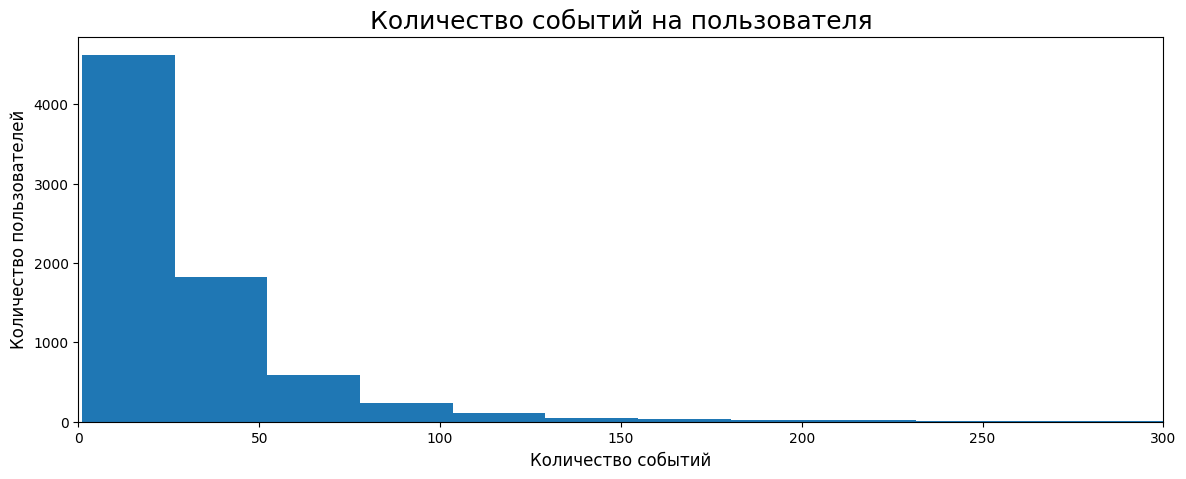

In [13]:
plt.figure(figsize=(14,5))
plt.hist(pivot['event_name'], bins=90)
plt.xlim(0, 300)
plt.title('Количество событий на пользователя', fontsize=18)
plt.xlabel('Количество событий', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12);

Проверим, охватывают ли полные данные весь период с 25.07.2019 по 07.08.2019, построив гистограмму по дате и времени

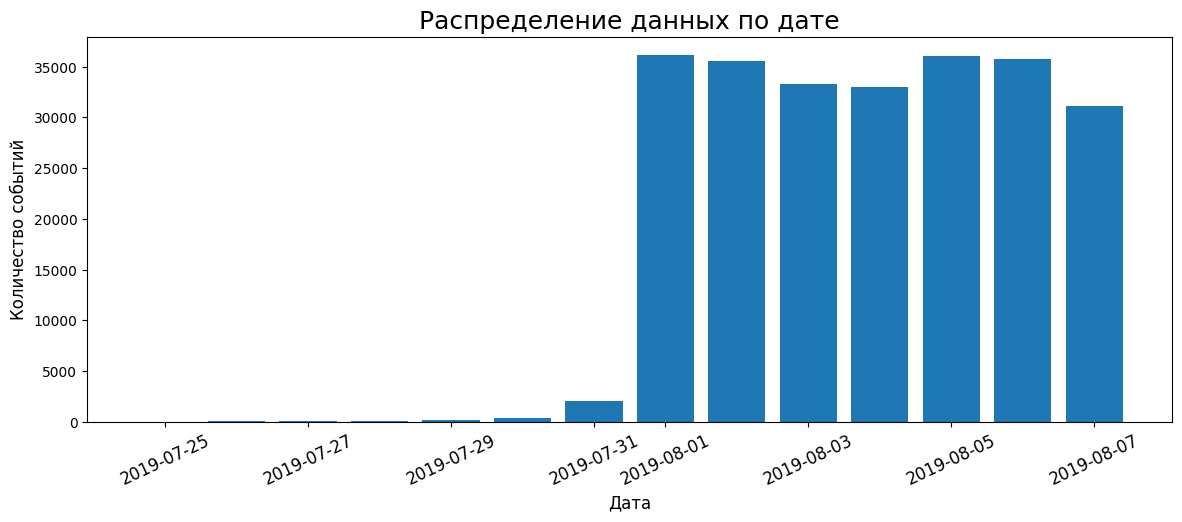

In [14]:
plt.figure(figsize=(14,5))
counts = df['date'].value_counts()
plt.bar(counts.index, counts.values)
plt.xticks(rotation=25, fontsize=12)
plt.title('Распределение данных по дате', fontsize=18)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество событий', fontsize=12);

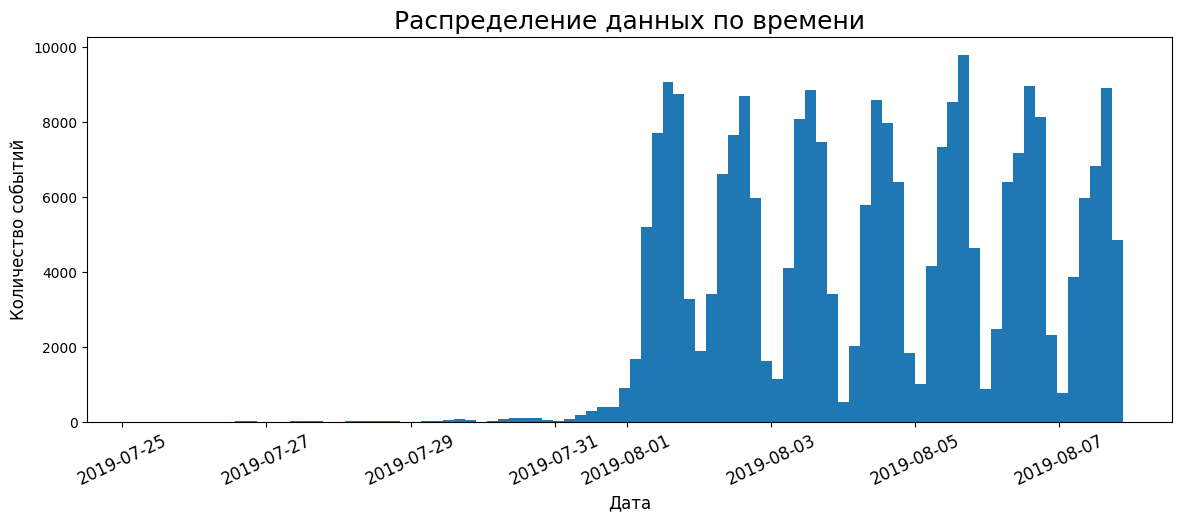

In [15]:
plt.figure(figsize=(14,5))
plt.hist(df['event_time'], bins=90)
plt.xticks(rotation=25, fontsize=12)
plt.title('Распределение данных по времени', fontsize=18)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество событий', fontsize=12);

По графику видим, что полные данные охватывают период c 01.08.2019 по 07.08.2019. Посмотрим, сколько данных потеряем при удалении более старых данных, то есть ранее 01.08.2019

In [16]:
events = len(df)
users = df['user_id'].nunique()
df = df.query("event_time >= '2019-08-01'")
print(f"""Количество удаленных событий: {events - len(df)}
Процент удаленных событий: {round((events - len(df))/events * 100,2)}
Количество удаленных пользователей: {users - df['user_id'].nunique()}
Процент удаленных пользователей: {round((users - df['user_id'].nunique())/users * 100,2)}
В среднем на пользователя приходится {round(len(df)/df['user_id'].nunique())} события""")

Количество удаленных событий: 2826
Процент удаленных событий: 1.16
Количество удаленных пользователей: 17
Процент удаленных пользователей: 0.23
В среднем на пользователя приходится 32 события


Проверим, что пользователи есть во всех трех экспериментальных группах

In [17]:
df.groupby('group')['user_id'].agg('nunique')

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Убедились, что нет пользователей, которые участвовали более чем в одной группе, а также, что пользователи есть во всех трех группах. В датасете данные охватывают период с 25.07.2019 по 07.08.2019, но по графику увидели, что до 01.08.2019 данные не полные. Удалили устаревшие данные, потеряв при этом чуть больше 1 % событий и менее 1 % пользователей, среднее количество событий на одного пользователя не изменилось, и составляет 32 события

### Анализ воронки событий

Соберем данные в таблицу. Для каждого вида события посчитаем количество событий, количество уникальных пользователей, долю пользователей, которые хоть раз совершали событие

In [18]:
event = df.pivot_table(index='event_name', values='user_id', aggfunc=['count', 'nunique']).reset_index()
event.columns = ['event_name', 'count_events', 'unique_users']
event['perc'] = round(event['unique_users']/df['user_id'].nunique() * 100, 2)
event.sort_values(by=['count_events', 'unique_users'], ascending=False)

,event_name,count_events,unique_users,perc
1,MainScreenAppear,117328,7419,98.47
2,OffersScreenAppear,46333,4593,60.96
0,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


Видим, что таблица, отсортированная по количеству событий (порядок сортировки по количеству уникальных пользоватлей не меняется) показывает логичную, последовательную цепочку. То есть сначала пользователь видит главное меню, затем предложения, корзину и экран успешной оплаты. А вот обучение, судя по всему, в приложении можно пропустить, потому оно наименее посещаемое в приложении, а чтобы пройти обучение вряд ли необходимо что-либо купить. Поэтому, событие - обучение, можно исключить из дальнейшего анализа

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [19]:
event = event.query('event_name != "Tutorial"').sort_values(by=['count_events', 'unique_users'], ascending=False)

In [20]:
event['funnel'] = round(100 + event['unique_users'].pct_change() * 100, 1)
event['funnel'] = event['funnel'].fillna(100)
event

,event_name,count_events,unique_users,perc,funnel
1,MainScreenAppear,117328,7419,98.47,100.0
2,OffersScreenAppear,46333,4593,60.96,61.9
0,CartScreenAppear,42303,3734,49.56,81.3
3,PaymentScreenSuccessful,33918,3539,46.97,94.8


Визуализируем воронку событий

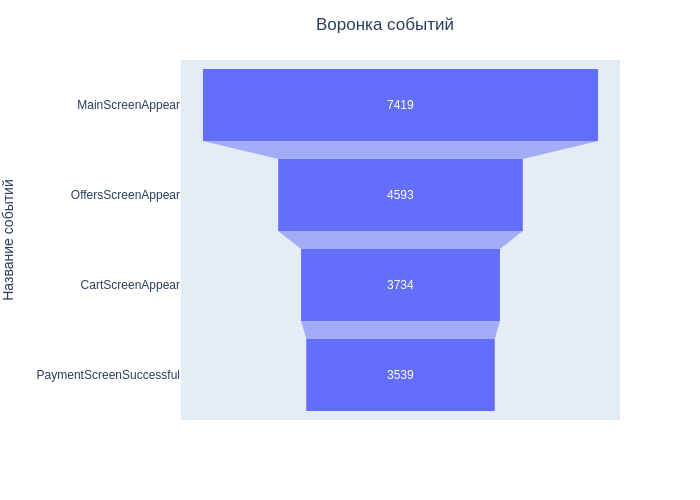

In [21]:
fig = px.funnel(event, y='event_name', x='unique_users', hover_data=['funnel'])
fig.update_layout(
    yaxis_title='Название событий',
    title_text='Воронка событий',
    title_x=0.55
)
fig.show()

Воронка событий приложения упорядочена следующим образом: главное меню, предложения, корзина, успешная оплата. Шаг обучения был исключен, так как он является необязательным этапом, и может быть пропущен. Наибольшее количество пользователей теряется на шаге предложений, потери составляют более 38 % пользователей. А от первого события до оплаты доходят примерно 47 % пользователей

### Исследование результатов эксперимента

In [22]:
users_group = df.pivot_table(index='group', values='user_id', aggfunc=['nunique']).reset_index()
users_group.columns = ['group', 'unique_users']
users_group

,group,unique_users
0,246,2484
1,247,2513
2,248,2537


Количество пользователей в каждой группе примерно одинаковое. Для проверки гипотез о равенстве долей будем использовать z-критерий. Так как необходимо провести несколько сравнений на одних и тех же данных, то тест будет множественный. При множественном тесте вероятность ошибки первого рода возрастает с каждой проверкой, чтобы избежать вероятность такой ошибки, будем использовать поправку Бонферрони. Определим, сколько тестов будем проводить: имеем 4 события и 3 группы, плюс еще одна группа - общая контрольная, итого 16 проверок, то есть заданный уровень значимости нужно будет поделить на 16. Соберем данные с количеством пользователей по каждой группе и событию, исключив собитие обучения, а также посчитаем количество пользователей в каждой группе без учета события

In [23]:
df = df.query('event_name != "Tutorial"')
event_group = df.pivot_table(index='event_name', values='user_id', columns='group', aggfunc='nunique').reset_index()
event_group.columns = ['event_name', '246', '247', '248']
event_group['control'] = event_group['246']  + event_group['247']
event_group

,event_name,246,247,248,control
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [24]:
group = df.pivot_table(index='group', values='user_id', aggfunc=['nunique']).reset_index()
group.columns = ['group', 'unique_users']
group

,group,unique_users
0,246,2483
1,247,2512
2,248,2535


Визуализируем воронку событий по группам

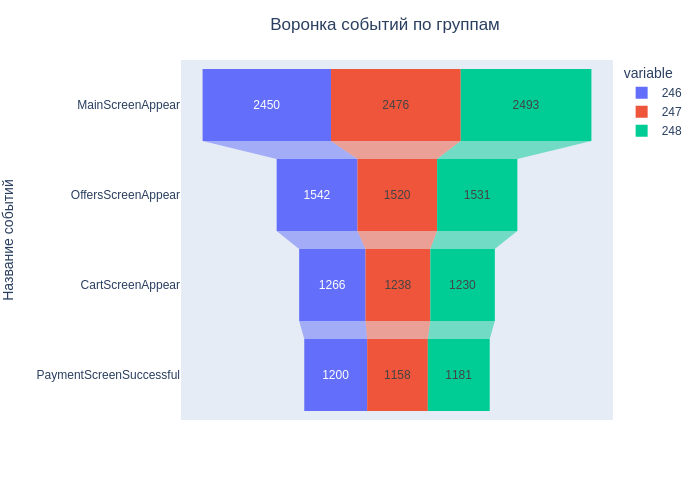

In [25]:
fig = px.funnel(event_group.sort_values(by='246', ascending=False), y='event_name', x=['246', '247', '248'])
fig.update_layout(
    yaxis_title='Название событий',
    title_text='Воронка событий по группам',
    title_x=0.55
)
fig.show()

Создадим функцию для проверки гипотез о равенстве долей. Зададим уровень значимости равный 0.05

In [26]:
def test(event1, event2, group1, group2):
    # зададим уровень значимости и поправку Бонферрони
    alpha = .05
    bnf = alpha/16
    # пропорции пользователей, совершивших событие
    p1 = event1 / group1
    p2 = event2 / group2
    # комбинированная пропорция
    p_combined = (event1 + event2) / (group1 + group2)
    # разница пропорций
    difference = p1 - p2
    # статистика в стандартных отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group1 + 1/group2))
    # стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = round((1 - distr.cdf(abs(z_value))) * 2, 3)

    print('p-значение: ', p_value)

    if p_value < bnf:
        print('Отвергаем нулевую гипотезу, различия между долями есть')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

Проврим, есть ли статистическая разница между двумя контрольными группами 246 и 247, то есть проведем А/А-тест. Сформулируем гипотезы:

* Нулевая: доли пользователей, совершивших событие в контрольных группах 246 и 247 одинаковы.
* Альтернативная: доли пользователей, совершивших событие в контрольных группах 246 и 247 различны.

In [27]:
for event_name in event_group['event_name']:
    print('Группы 246 и 247, событие:', event_name)
    test(event_group.loc[event_group['event_name'] == event_name, '246'].values[0],
      event_group.loc[event_group['event_name'] == event_name, '247'].values[0],
      group.iloc[0]['unique_users'], group.iloc[1]['unique_users'])
    print()

Группы 246 и 247, событие: CartScreenAppear
p-значение:  0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 246 и 247, событие: MainScreenAppear
p-значение:  0.753
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 246 и 247, событие: OffersScreenAppear
p-значение:  0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 246 и 247, событие: PaymentScreenSuccessful
p-значение:  0.114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



По всем совершенным событиям не наблюдаются различий в долях пользователей в контрольных группах 246 и 247, а значит, можно сказать, что разбиение на группы было произведено корректно

Проверим, есть ли статистическая разница между контрольной группой 246 и экспериментальной группой 248. Сформулируем гипотезы:

* Нулевая: доли пользователей, совершивших событие в контрольной группе 246 и экспериментальной группе 248 одинаковы.
* Альтернативная: доли пользователей, совершивших событие в контрольной группе 246 и экспериментальной группе 248 различны.

In [28]:
for event_name in event_group['event_name']:
    print('Группы 246 и 248, событие:', event_name)
    test(event_group.loc[event_group['event_name'] == event_name, '246'].values[0],
      event_group.loc[event_group['event_name'] == event_name, '248'].values[0],
      group.iloc[0]['unique_users'], group.iloc[2]['unique_users'])
    print()

Группы 246 и 248, событие: CartScreenAppear
p-значение:  0.081
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 246 и 248, событие: MainScreenAppear
p-значение:  0.339
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 246 и 248, событие: OffersScreenAppear
p-значение:  0.214
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 246 и 248, событие: PaymentScreenSuccessful
p-значение:  0.217
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Различия между долями пользователей, совершивших события в контрольной группе 246 и экспериментальной группе 248 не были обнаружены

Проверим, есть ли статистическая разница между контрольной группой 247 и экспериментальной группой 248. Сформулируем гипотезы:

* Нулевая: доли пользователей, совершивших событие в контрольной группе 247 и экспериментальной группе 248 одинаковы.
* Альтернативная: доли пользователей, совершивших событие в контрольной группе 247 и экспериментальной группе 248 различны.

In [29]:
for event_name in event_group['event_name']:
    print('Группы 247 и 248, событие:', event_name)
    test(event_group.loc[event_group['event_name'] == event_name, '247'].values[0],
      event_group.loc[event_group['event_name'] == event_name, '248'].values[0],
      group.iloc[1]['unique_users'], group.iloc[2]['unique_users'])
    print()

Группы 247 и 248, событие: CartScreenAppear
p-значение:  0.588
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 247 и 248, событие: MainScreenAppear
p-значение:  0.519
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 247 и 248, событие: OffersScreenAppear
p-значение:  0.933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 247 и 248, событие: PaymentScreenSuccessful
p-значение:  0.728
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Также и между группами 247 и 248 не удалось обнаружить различия между долями пользователей ни по одному совершенному собитию

Теперь проверим есть ли различия между полной контрольной группой (246 и 247) и  экспериментальной группой 248. Сформулируем гипотезы:

* Нулевая: доли пользователей, совершивших событие в полной контрольной группе и экспериментальной группе 248 одинаковы.
* Альтернативная: доли пользователей, совершивших событие в полной контрольной группе и экспериментальной группе 248 различны.

In [30]:
for event_name in event_group['event_name']:
    print('Группы контрольная и 248, событие:', event_name)
    test(event_group.loc[event_group['event_name'] == event_name, 'control'].values[0],
      event_group.loc[event_group['event_name'] == event_name, '248'].values[0],
      group.iloc[0]['unique_users'] + group.iloc[1]['unique_users'], group.iloc[2]['unique_users'])
    print()

Группы контрольная и 248, событие: CartScreenAppear
p-значение:  0.187
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы контрольная и 248, событие: MainScreenAppear
p-значение:  0.349
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы контрольная и 248, событие: OffersScreenAppear
p-значение:  0.446
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы контрольная и 248, событие: PaymentScreenSuccessful
p-значение:  0.611
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Не удалось обнаружить различия между долями пользователей в полной контрольной и экпериментальной группах по каждому совершенному событию

Для определения различий между долями использовали z-критерий, уровень значимости (alpha) установили равным 0.05. Так как тест был множественным, и проводилось 16 проверок гипотез, была внесена поправка Бонферрони, которая предотвращает возникновение ошибки первого рода (ложное отвержение нулевой гипотезы). Сначала проверили, что доли пользователей обеих контрольных групп не отличаются, а значит распределение по группам было произведено корректно. По результатам тестирования контрольных групп с экспериментальной, не было обнаружено статистически значимых различий между долями пользователей по всем совершенным событиям

### Выводы

В ходе работы изучили предоставленный датасет и подготовили его к дальнейшему анализу. Были обнаружены и удалены явные дубликаты, их доля составила менее 1 % данных, пропуски не обнаружены. Изменили названия колонок, перевели дату в правильный формат.

При проверке данных было установлено, что пользователи есть во всех трех группах, а также, что в данных нет пользователей, которые участвовали более чем в одной группе. Данные охватывают период с 25.07.2019 по 07.08.2019, но в дальнейшем рассматривался период с 01.08.2019 по 07.08.2019, так как по графику увидели, что данные до 01.08.2019 не полные. При удалении устаревших данных потеряли всего чуть больше 1 % событий и менее 1 % пользователей. Среднее количество событий на одного пользователя составляет 32 события.

Анализ воронки событий показал, что порядок воронки продаж в мобильном приложении следующий: главное меню, предложения, корзина, успешная оплата. Шаг обучения в дальнейшем анализе был исключен, так как данный этап по количеству пользователей был последний, но он явно не предполагает покупку, а следовательно этап обучения не обязательный и может быть пропущен. От первого события до оплаты доходят около 47% пользователей, наибольшее количество пользователей теряется на этапе предложений, потери составляют более 38 %.

На этапе исследования результатов А/А/В-тестирования применяли z-критерий с поправкой Бонферрони, поскольку тестирование было множественным и предполагало проверку 16 гипотез. Убедились, что в обеих контрольных группах нет различий в долях пользователей по каждому событию, это означает, что разделение по группам было произведено корректно. При сравнении долей пользователей контрольных групп с экспериментальной также не было обнаружено разницы по каждому совершенному событию. То есть можно сделать вывод о том, что вводимые изменения по замене шрифтов во всем приложении не повлияют на поведение пользователей и данное изменение можно не вводить